# Product: Print the all-sky best-fit reflex motion map


In [1]:

# basic imports
from __future__ import print_function
import numpy as np
from numpy.linalg import eig, inv
import time

# plotting elements
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.cm as cm
import matplotlib as mpl
mpl.rcParams['font.weight'] = 'medium'
mpl.rcParams['xtick.labelsize'] = 10
mpl.rcParams['ytick.labelsize'] = 10
cmap = cm.RdBu_r


import scipy.interpolate as interpolate
from scipy.interpolate import UnivariateSpline
import scipy

# ipython reload capabilities for edits to external code
%load_ext autoreload
%autoreload 2


import reflexmotion.posteriorreader as pr
import reflexmotion.reflex as rm



In [2]:
# make a rough outline of the BHB coverage (commensurate with SDSS coverage)
from reflexmotion import kde as kde_3d

X11 = np.genfromtxt('data/Xue2011BHB.txt',\
                        dtype={'names': ("RA","Dec","Glon","Glat",\
                                         "gmag","ug","gr","D0.2","fm",\
                                         "cHg","bHg","d","r",\
                                         "x","y","z","HRV",\
                                         "eHRV","Vgal","DR8","Sloan",\
                                         "SimbadName"),\
                             'formats': ('f8','f8','f8','f8',\
                                        'f8','f8','f8','f8','f8',\
                                        'f8','f8','f8','f8',\
                                        'f8','f8','f8','f8',\
                                        'f8','f8','f8','f8',\
                                         'S20')},\
                 skip_header=77,delimiter=';')

# unify coordinate systems
bhbl = X11['Glon']
bhbl[bhbl > 180.] -= 360.

bhbb = X11['Glat']

xx,yy,bhbw = kde_3d.total_kde_two(bhbl,-bhbb,\
                                       gridsize=256,\
                                       extents=(-179,179.,-89,89),\
                                       #extents=(0.,360.,-90,90),\
                                       #weights=PSPDump.mass/np.cos(halob),\
                                       ktype='gaussian',npower=6.)


#plt.contour(xx,yy,np.log10(bhbw),[-5.],colors='black')

## Make the Reflex Motion Model

In [3]:
from scipy.interpolate import RectBivariateSpline,interp2d

In [4]:
def haversine(lon1, lat1, lon2, lat2,deg=True):
    """
    Calculate the great circle distance between two points 
    on a sphere (specified in decimal degrees or radians)
    """
    # convert decimal degrees to radians 
    if deg:
        lon1, lat1, lon2, lat2 = (np.pi/180.)*lon1, (np.pi/180.)*lat1, (np.pi/180.)*lon2, (np.pi/180.)*lat2

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2. * np.arcsin(np.sqrt(a)) 
    if deg:
        return (180./np.pi)*c
    else:
        return c

In [23]:
ALL     = pr.read_posterior('posteriors/all_d040150_sgr20_L3000_cov.posteriors2')


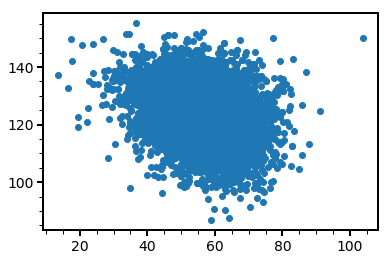

In [6]:
plt.scatter(ALL['phi'],90-ALL['theta'])

In [7]:
phi = 56.
theta = 90+34.
#phi = 0.
#theta = 0.
psi = 0.

twopi=False
travel='d'

pointres=40

l,b,dist,mul,mub,vlos = rm.make_model(phi,theta,psi=psi,pointres=pointres,travel=travel,flip=True)

l,b,xv,yv,zv = rm.make_model_cartesian(phi,theta,psi=psi,pointres=pointres,travel=travel,flip=True)




In [8]:
sep = haversine(l, b, 0.0, 0.0,deg=False)
print(l[sep.argmin()],b[sep.argmin()],mub[sep.argmin()])

6.245876721065176 0.03061618005828559 -0.0001207296591575464


In [9]:
phi = 90
theta = 90
l,b,xv,yv,zv = rm.make_model_cartesian(phi,theta,psi=psi,pointres=pointres,travel=travel,flip=True)
print(xv,yv,zv)


[6.123234e-17 6.123234e-17 6.123234e-17 ... 6.123234e-17 6.123234e-17
 6.123234e-17] [1. 1. 1. ... 1. 1. 1.] [6.123234e-17 6.123234e-17 6.123234e-17 ... 6.123234e-17 6.123234e-17
 6.123234e-17]


In [10]:
# print tables of model solutions

f = open('processed/PP20_correction_model_cartesian.txt','w')

nsamples = 2000

for n in range(0,nsamples):
    phi = ALL['phi'][n]
    theta = 90.-ALL['theta'][n]
    pointres=50
    travel='d'
    l,b,xv,yv,zv = rm.make_model_cartesian(phi,theta,psi=psi,pointres=pointres,travel=travel,flip=True)

    np.array([l,b,ALL['vtravel'][n]*xv,ALL['vtravel'][n]*yv,ALL['vtravel'][n]*zv]).astype('float16').tofile(f)

f.close()



In [11]:
# print tables of model solutions

f = open('processed/PP20_correction_model.txt','w')

nsamples = 2000

for n in range(0,nsamples):
    phi = ALL['phi'][n]
    theta = 90.-ALL['theta'][n]
    pointres=50
    travel='u'
    l,b,dist,mul,mub,vlos = rm.make_model(phi,theta,psi=psi,pointres=pointres,travel=travel,flip=True)

    np.array([l,b,ALL['vtravel'][n]*mul,ALL['vtravel'][n]*mub,ALL['vtravel'][n]*vlos]).astype('float16').tofile(f)

f.close()


In [12]:
#M = np.memmap('/Users/mpetersen/Downloads/PP20_correction_model.txt',dtype='float16',shape=(nsamples,5,pointres*pointres))


M = np.memmap('processed/PP20_correction_model_cartesian.txt',dtype='float16',shape=(nsamples,5,pointres*pointres))


print(M[nsamples-1,1,0:10])
print(b[0:10])

[0.8975 0.8975 0.8975 0.8975 0.8975 0.8975 0.8975 0.8975 0.8975 0.8975]
[0.89739814 0.89739814 0.89739814 0.89739814 0.89739814 0.89739814
 0.89739814 0.89739814 0.89739814 0.89739814]


In [13]:
def haversine(lon1, lat1, lon2, lat2,deg=True):
    """
    Calculate the great circle distance between two points 
    on a sphere (specified in decimal degrees or radians)
    """
    # convert decimal degrees to radians 
    if deg:
        lon1, lat1, lon2, lat2 = (np.pi/180.)*lon1, (np.pi/180.)*lat1, (np.pi/180.)*lon2, (np.pi/180.)*lat2

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2. * np.arcsin(np.sqrt(a)) 
    if deg:
        return (180./np.pi)*c
    else:
        return c
    

def draw_corrections_cartesian(lpos,bpos,M,ncorr=2000):
    """
    
    
    inputs
    -----------
    lpos  : in radians
    bpos  : in radians
    M
    ncorr
    
    
    """
    xcorr = np.zeros(ncorr)
    ycorr = np.zeros(ncorr)
    zcorr = np.zeros(ncorr)
    for n in range(0,ncorr):
        ntest = np.random.randint(0,M.shape[0])
        sep = haversine(M[ntest,0],M[ntest,1], lpos, bpos,deg=False)
        print((180./np.pi)*M[ntest,0,sep.argmin()],(180./np.pi)*M[ntest,1,sep.argmin()])
        xcorr[n]= M[ntest,2,sep.argmin()]
        ycorr[n]= M[ntest,3,sep.argmin()]
        zcorr[n]= M[ntest,4,sep.argmin()]
    return xcorr,ycorr,zcorr

In [14]:
M[6,3,0:20]

memmap([32.66, 32.66, 32.66, 32.66, 32.66, 32.66, 32.66, 32.66, 32.66,
        32.66, 32.66, 32.66, 32.66, 32.66, 32.66, 32.66, 32.66, 32.66,
        32.66, 32.66], dtype=float16)

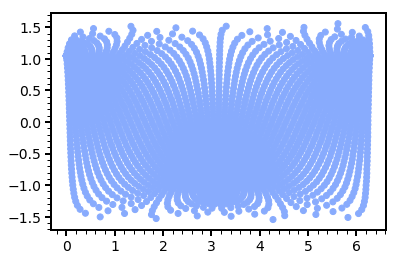

In [15]:
plt.scatter(M[0,0],M[0,1],color=cm.coolwarm((M[0,4]+25)/50.))

In [16]:
print(nsamples,pointres)
M = np.memmap('processed/PP20_correction_model_cartesian.txt',dtype='float16',shape=(nsamples,5,pointres*pointres))

xcorr,ycorr,zcorr = draw_corrections_cartesian(np.pi/2.,np.pi/4.,M,ncorr=10)
print(xcorr,zcorr)


2000 50
90.36394913440229 47.00044413182534
92.65801843131283 46.9444912221446
91.31514859897496 48.14747878028061
92.71397134099357 45.993291757571946
88.96512639238368 45.23792747688189
92.60206552163207 47.33616158990981
92.09848933450537 47.86771423187688
87.73416237940731 42.915881725131
91.65086605705942 47.19627931570795
92.65801843131283 47.559973228632785
[18.15625   11.4921875 15.6796875  9.4375    16.203125  17.03125
 17.359375   4.5234375  9.78125   15.609375 ] [-15.0078125 -23.328125  -18.96875   -21.359375  -12.6328125 -29.890625
 -21.546875  -16.109375  -21.9375     -8.2578125]


6.029742491765391 1.265814103406896 0.6821274257307902


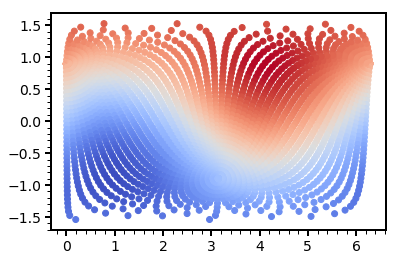

In [18]:
plt.scatter(l,b,color=cm.coolwarm(0.5*(vlos+1.)))


def draw_corrections(lpos,bpos,M,ncorr=2000):
    vloscorr = np.zeros(ncorr)
    mulcorr = np.zeros(ncorr)
    mubcorr = np.zeros(ncorr)
    for n in range(0,ncorr):
        ntest = np.random.randint(0,M.shape[0])
        sep = haversine(M[ntest,0],M[ntest,1], lpos, bpos,deg=False)
        mulcorr[n]= M[ntest,2,sep.argmin()]
        mubcorr[n]= M[ntest,3,sep.argmin()]
        vloscorr[n]= M[ntest,4,sep.argmin()]
    return mulcorr,mubcorr,vloscorr
        
        
mulcorr,mubcorr,vloscorr = draw_corrections(0.,0.,M,ncorr=2000)

print(l[sep.argmin()],b[sep.argmin()],vlos[sep.argmin()])



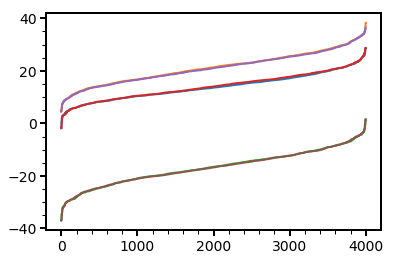

In [19]:
# read in the model uncertainty file
M = np.memmap('processed/PP20_correction_model_cartesian.txt',dtype='float16',shape=(nsamples,5,pointres*pointres))

xcorr,ycorr,zcorr = draw_corrections(np.pi/2.,np.pi,M,ncorr=4000)

plt.plot(xcorr[xcorr.argsort()])
plt.plot(ycorr[ycorr.argsort()])
plt.plot(zcorr[zcorr.argsort()])

xcorr,ycorr,zcorr = draw_corrections(0.0,0.0,M,ncorr=4000)

plt.plot(xcorr[xcorr.argsort()])
plt.plot(ycorr[ycorr.argsort()])
plt.plot(zcorr[zcorr.argsort()])



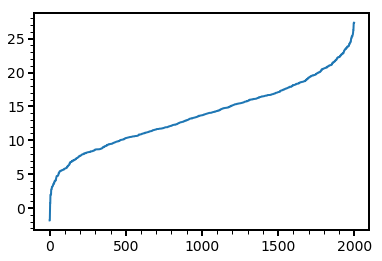

In [20]:
mulcorr,mubcorr,vloscorr = draw_corrections(0.,0.,M,ncorr=2000)

plt.plot(mulcorr[mulcorr.argsort()])

In [21]:
f = interp2d(l, b, vlos, kind='linear')

